# Model Selection and Evaluation for Credit Risk

## Initial steps

Load libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, accuracy_score
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score



Reproducibility and display

In [2]:
np.random.seed(42)
pd.options.display.max_columns = 200
sns.set_palette('Set2')

We load the feature-engineered dataset produced by the `feature_engineering` notebook

In [3]:
df = pd.read_csv('../data/credit_risk_fe.csv')
print(f'Loaded dataset shape: {df.shape}')
df.head()

Loaded dataset shape: (31679, 18)


,loan_percent_income,person_income,loan_int_rate,loan_amnt,loan_grade_D,person_home_ownership_MORTGAGE,person_age,person_emp_length,person_home_ownership_OWN,loan_intent_DEBTCONSOLIDATION,loan_intent_MEDICAL,loan_grade_E,loan_grade_C,default_flag,loan_intent_HOMEIMPROVEMENT,loan_grade_A,loan_intent_EDUCATION,loan_status
0,-0.655048,-1.078118,0.034226,-1.367162,0.0,0.0,-1.083264,0.054013,1.0,0.0,0.0,0.0,0.0,-0.464799,0.0,0.0,1.0,0
1,3.767765,-1.078118,0.597715,-0.656740,0.0,1.0,-0.439486,-0.937341,0.0,0.0,1.0,0.0,1.0,-0.464799,0.0,0.0,0.0,1
2,3.391355,-0.018763,1.366405,4.000473,0.0,0.0,-0.761375,-0.193826,0.0,0.0,1.0,0.0,1.0,-0.464799,0.0,0.0,0.0,1
3,3.579560,-0.229118,1.053718,4.000473,0.0,0.0,-0.600431,0.797529,0.0,0.0,1.0,0.0,1.0,2.151469,0.0,0.0,0.0,1
4,0.756488,-1.072433,-1.268639,-1.130355,0.0,0.0,-1.083264,-0.689503,1.0,0.0,0.0,0.0,0.0,-0.464799,0.0,1.0,0.0,1


## Data preparation

Split features and target variable

In [4]:
X = df.drop(columns=['loan_status'])
y = df['loan_status']

print(f'Class balance: {(y.value_counts() / len(y) * 100).round(2).to_dict()}')

Class balance: {0: 78.46, 1: 21.54}


Create train-test split with stratification to preserve class distribution

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Model training

We select some baseline moddels to compare: Logistic Regression, Random Forest, XGBoost, and SVM and we train them.

In [6]:
# Initialize models with fixed random states for reproducibility
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        class_weight='balanced', # Ajusts weights automatically
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', # Ajusts weights automatically
        random_state=42, 
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, 
        scale_pos_weight=ratio, # Multiplies the positive class weight by the imbalance ratio
        random_state=42, 
        eval_metric='logloss'
    ),
    'SVM': SVC(
        kernel='rbf', 
        class_weight='balanced', # Funddamental for SVM to handle imbalance
        probability=True, 
        random_state=42
    )
}

# Train all models
trained_models = {}
for name, model in models.items():
    print(f'Training {name}...')
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f'  - {name} trained')
print('\nAll models trained successfully')

Training Logistic Regression...
  - Logistic Regression trained
Training Random Forest...
  - Random Forest trained
Training XGBoost...
  - XGBoost trained
Training SVM...
  - SVM trained

All models trained successfully


## Model evaluation on test set

Calculate multiple evaluation metrics for each model: Accuracy, Precission, Recall, F1-Score and ROC-AUC

In [7]:
results = []

for name, model in trained_models.items():
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }
    results.append(metrics)

results_df = pd.DataFrame(results).set_index('Model')
print('\nTest Set Performance Metrics:')
print(results_df.round(4))


Test Set Performance Metrics:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                              
Logistic Regression    0.8057     0.5334  0.7839    0.6348   0.8722
Random Forest          0.9361     0.9688  0.7267    0.8305   0.9321
XGBoost                0.9235     0.8379  0.7993    0.8181   0.9447
SVM                    0.8827     0.7121  0.7648    0.7375   0.9094


To analyze the results we will focus on the Recall and F1-Score metrics since false negatives are more costly in credit risk scenarios. All models have a similar Recall but the Random Forest and XGBoost models have a significantly higher F1-Score, indicating a better balance between precision and recall.

Visualize model performance comparison

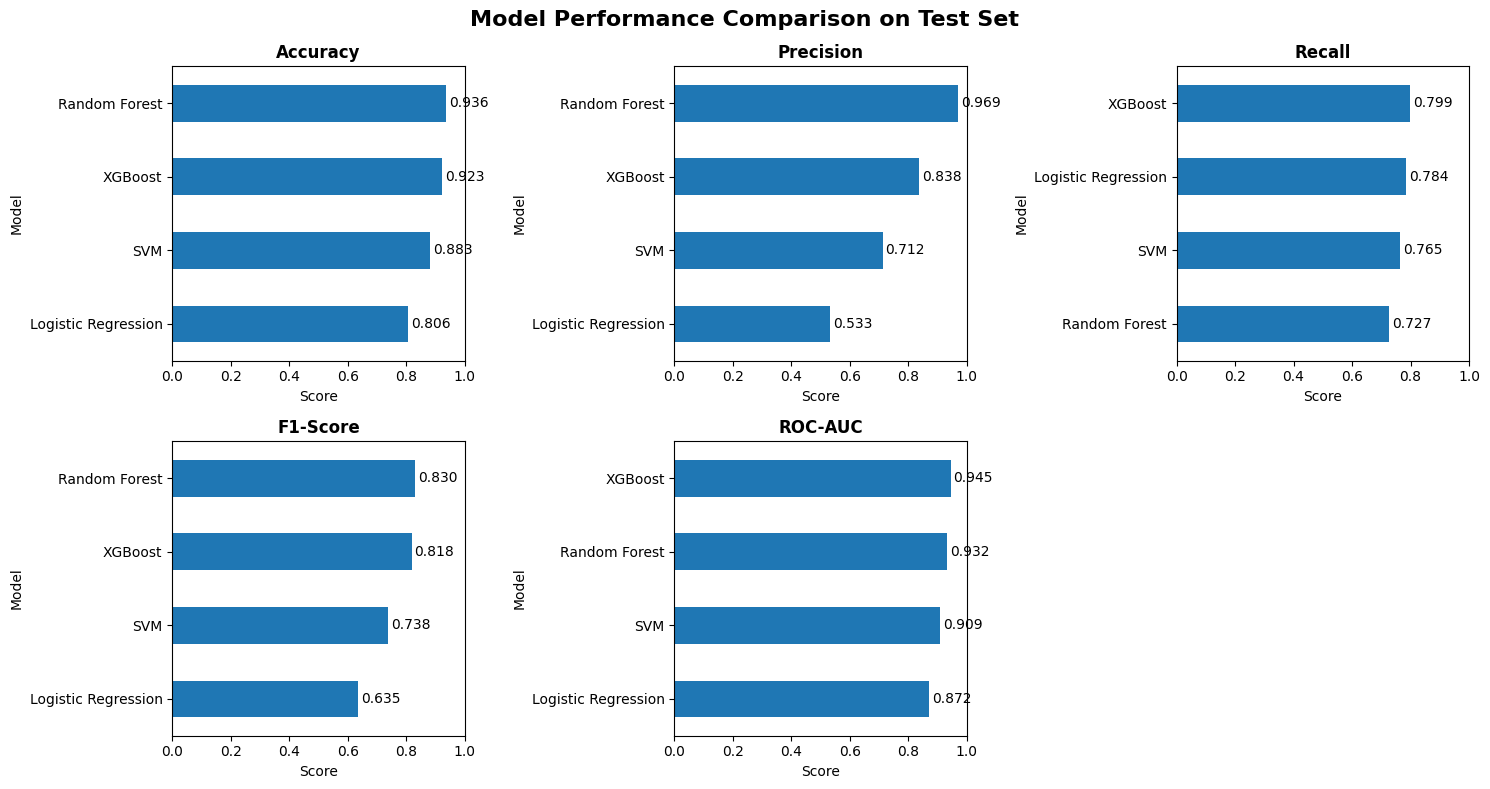

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Model Performance Comparison on Test Set', fontsize=16, fontweight='bold')

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes.flat[idx]
    results_df[metric].sort_values(ascending=True).plot(kind='barh', ax=ax, color='tab:blue')
    ax.set_title(metric, fontweight='bold')
    ax.set_xlabel('Score')
    ax.set_xlim([0, 1])
    for i, v in enumerate(results_df[metric].sort_values(ascending=True)):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center')

# Hide the last unused subplot
axes.flat[-1].set_visible(False)

plt.tight_layout()
plt.show()

We can see Random Forest leaing on almost all metrics, falling behind in recall, which might be a concern in a credit risk context where we want to minimize false negatives. XGBoost also performs well, especially in terms of recall so these two models will be our top candidates for further tuning and validation.

## Cross-validation evaluation

Perform 5-fold stratified cross-validation to assess model stability and generalization

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'}

cv_results = {}

for name, model in trained_models.items():
    print(f'\n{name} Cross-Validation Results:')
    cv_scores = cross_validate(model, X, y, cv=skf, scoring=scoring)
    cv_results[name] = cv_scores
    
    for metric in scoring.keys():
        scores = cv_scores[f'test_{metric}']
        print(f'  {metric.upper():10s}: {scores.mean():.4f} (+/- {scores.std():.4f})')


Logistic Regression Cross-Validation Results:
  ACCURACY  : 0.8062 (+/- 0.0035)
  PRECISION : 0.5348 (+/- 0.0061)
  RECALL    : 0.7733 (+/- 0.0077)
  F1        : 0.6323 (+/- 0.0050)
  ROC_AUC   : 0.8659 (+/- 0.0034)

Random Forest Cross-Validation Results:
  ACCURACY  : 0.9340 (+/- 0.0020)
  PRECISION : 0.9698 (+/- 0.0038)
  RECALL    : 0.7160 (+/- 0.0083)
  F1        : 0.8238 (+/- 0.0060)
  ROC_AUC   : 0.9284 (+/- 0.0042)

XGBoost Cross-Validation Results:
  ACCURACY  : 0.9191 (+/- 0.0035)
  PRECISION : 0.8241 (+/- 0.0095)
  RECALL    : 0.7938 (+/- 0.0085)
  F1        : 0.8087 (+/- 0.0083)
  ROC_AUC   : 0.9432 (+/- 0.0035)

SVM Cross-Validation Results:
  ACCURACY  : 0.8785 (+/- 0.0044)
  PRECISION : 0.7015 (+/- 0.0123)
  RECALL    : 0.7599 (+/- 0.0054)
  F1        : 0.7294 (+/- 0.0078)
  ROC_AUC   : 0.9044 (+/- 0.0040)


## ROC curves comparison

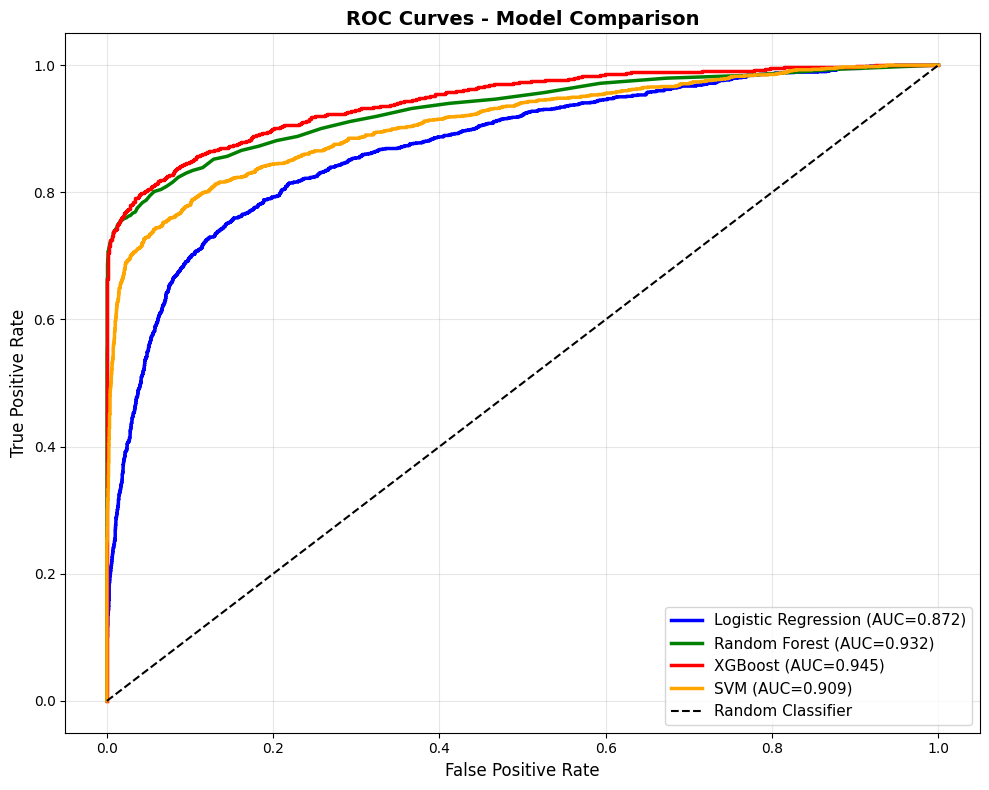

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'orange']

for (name, model), color in zip(trained_models.items(), colors):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})', linewidth=2.5, color=color)

# Plot diagonal (random classifier)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

XGBoost and Random Forest are the top performers in terms of ROC-AUC, with XGBoost slightly ahead. Logistic Regression and SVM also show decent performance, but they lag behind the ensemble methods.

## Feature importance analysis

Extract and visualize feature importance from tree-based models

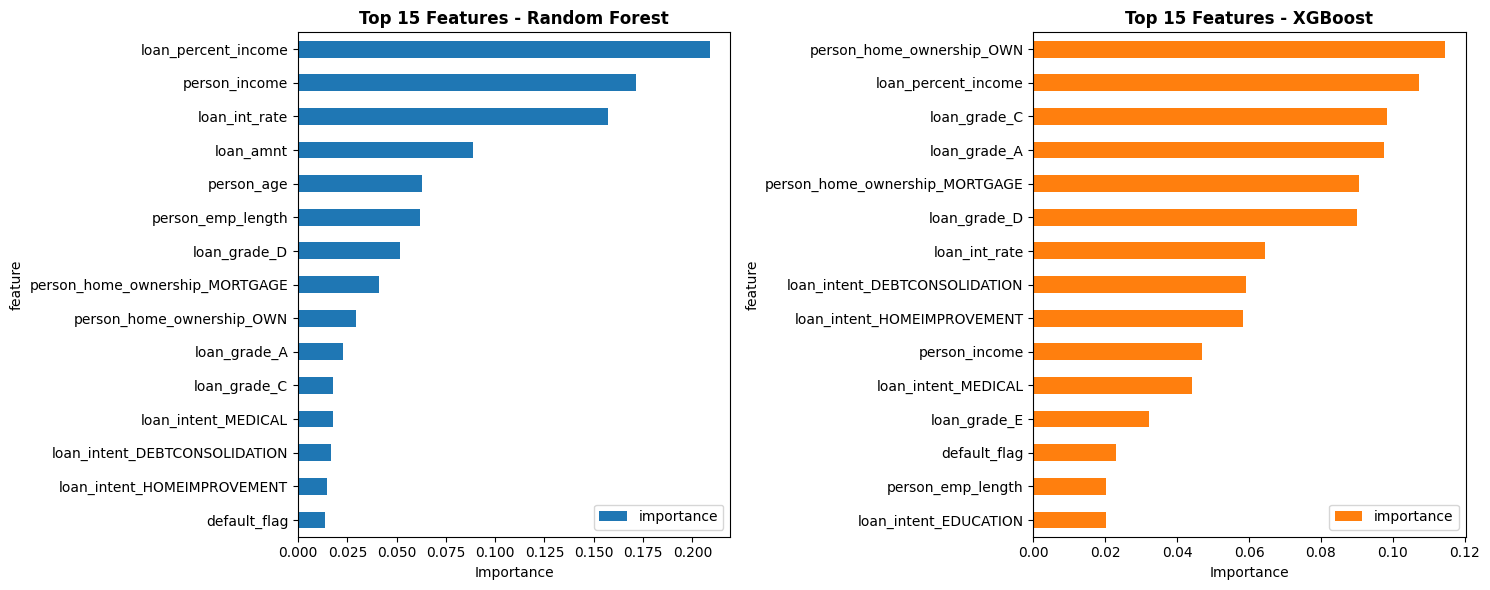

In [11]:
# Load feature names
feature_names = joblib.load('../models/feature_names.joblib')

# Random Forest feature importance
rf_model = trained_models['Random Forest']
rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top features plot
rf_importance.head(15).plot(x='feature', y='importance', kind='barh', ax=axes[0], color='tab:blue')
axes[0].set_title('Top 15 Features - Random Forest', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Importance')
axes[0].invert_yaxis()

# XGBoost feature importance
xgb_model = trained_models['XGBoost']
xgb_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

xgb_importance.head(15).plot(x='feature', y='importance', kind='barh', ax=axes[1], color='tab:orange')
axes[1].set_title('Top 15 Features - XGBoost', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

The top features on both models have some differences but keep consistent importance on indicators such as 'loan_percent_income', 'person_income', 'person_home_ownership_OWN' and 'person_home_ownership_MORTGAGE'.

## Confusion matrices

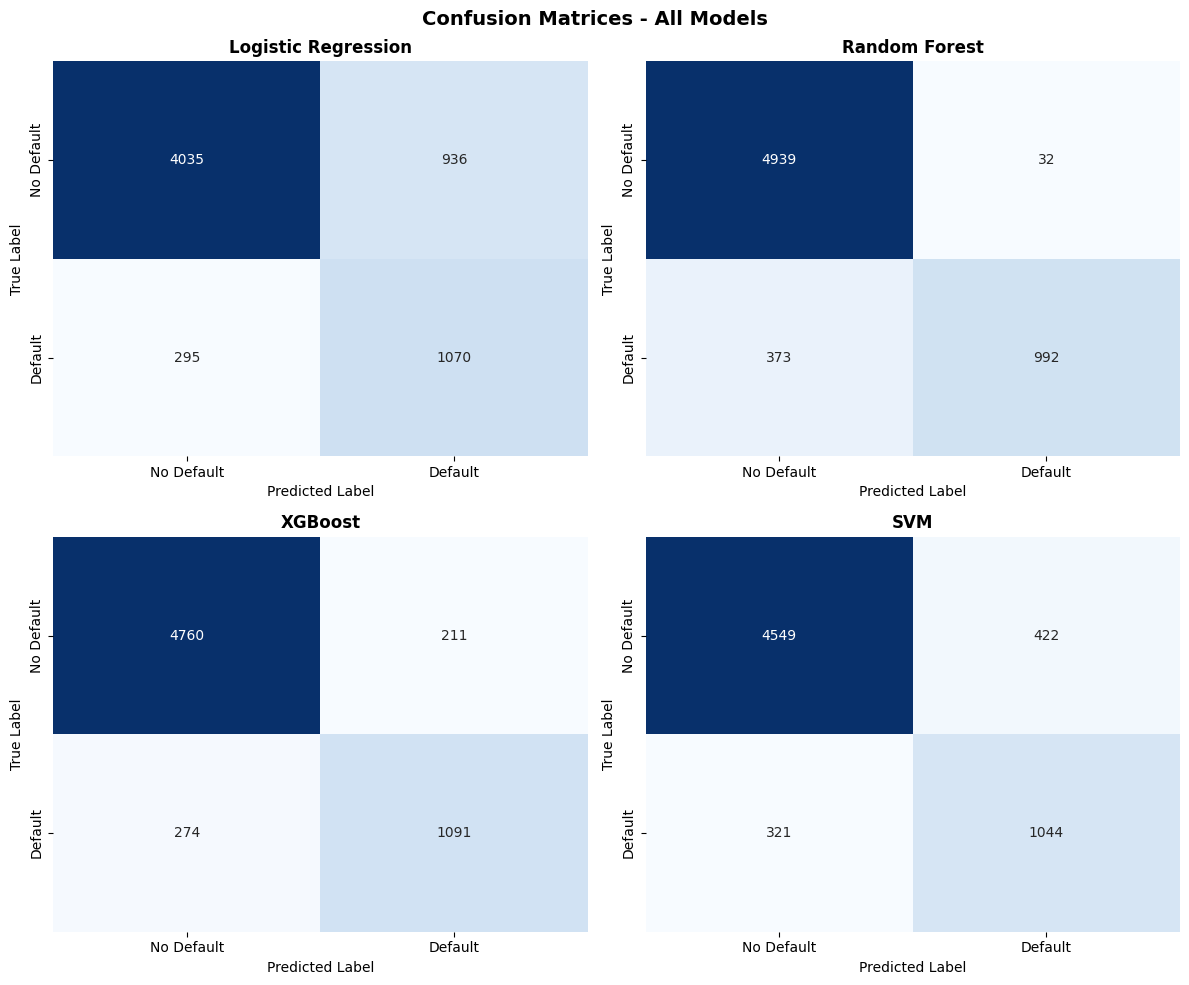

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Confusion Matrices - All Models', fontsize=14, fontweight='bold')

for idx, (name, model) in enumerate(trained_models.items()):
    ax = axes.flat[idx]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    ax.set_title(f'{name}', fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

Confusion matrixes show that all models do a good job classifying the negative cases but struggle more with the positive cases. Random Forest and XGBoost have better recall than Logistic Regression and SVM. This suggests that ensemble methods are more effective at capturing the complex patterns in the data that lead to defaults.

## Hyperparameter tuning

Optimize hyperparameters for top-performing models using GridSearchCV

In [13]:
# Define parameter grids for top models (XGBoost and Random Forest)
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [2, 4, 6]
    }
}

Hyperparameter tuning with recall as the primary scoring metric

In [14]:
tuned_models = {}

for model_name in ['XGBoost', 'Random Forest']:
    print(f'\nTuning {model_name}...')
    
    base_model = models[model_name]
    param_grid = param_grids[model_name]
    
    # Use recall as primary scoring metric for credit risk
    grid_search = GridSearchCV(
        base_model, 
        param_grid, 
        cv=5,
        scoring='recall',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    tuned_models[model_name] = grid_search.best_estimator_
    
    print(f'Best parameters for {model_name}:')
    print(f'  {grid_search.best_params_}')
    print(f'  Best CV Recall Score: {grid_search.best_score_:.4f}')


Tuning XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for XGBoost:
  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
  Best CV Recall Score: 0.7967

Tuning Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for Random Forest:
  {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 100}
  Best CV Recall Score: 0.7540


Evaluate tuned models on test set

In [15]:
tuned_results = []

for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'Model': f'{name} (Tuned)',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }
    tuned_results.append(metrics)

tuned_results_df = pd.DataFrame(tuned_results).set_index('Model')
print('\nTuned Models Test Set Performance Metrics:')
print(tuned_results_df.round(4))


Tuned Models Test Set Performance Metrics:
                       Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                                
XGBoost (Tuned)          0.9197     0.8194  0.8044    0.8118   0.9469
Random Forest (Tuned)    0.9100     0.8046  0.7692    0.7865   0.9261


As we can see the results of the tuned models show a slight reduction in accuracy and precission, but we get a better recall score, which is the most important metric for our use case. XGBoost is the best model based on recall performance, so we will select it as our final model for deployment after a threshold optimization process.

## Threshold Optimization

Find the optimal decision threshold to balance precision and recall.

In [26]:
# Get predictions from the best tuned model
final_model = tuned_models['XGBoost']
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Test different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    
    metrics = {
        'Threshold': threshold,
        'Precision': precision_score(y_test, y_pred_threshold, zero_division=0),
        'Recall': recall_score(y_test, y_pred_threshold, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred_threshold, zero_division=0),
        'Accuracy': accuracy_score(y_test, y_pred_threshold)
    }
    threshold_results.append(metrics)

threshold_df = pd.DataFrame(threshold_results)
print('Threshold Sensitivity Analysis:')
print(threshold_df.to_string(index=False))


Threshold Sensitivity Analysis:
 Threshold  Precision   Recall  F1-Score  Accuracy
      0.10   0.318149 0.982418  0.480645  0.542614
      0.15   0.380144 0.967766  0.545868  0.653093
      0.20   0.443795 0.945788  0.604118  0.732955
      0.25   0.505636 0.920147  0.652637  0.788984
      0.30   0.563972 0.894505  0.691785  0.828283
      0.35   0.631941 0.875458  0.734029  0.863321
      0.40   0.692170 0.848352  0.762344  0.886048
      0.45   0.757902 0.825641  0.790323  0.905619
      0.50   0.819403 0.804396  0.811830  0.919665
      0.55   0.865971 0.790476  0.826503  0.928504
      0.60   0.907216 0.773626  0.835113  0.934186
      0.65   0.929856 0.757509  0.834881  0.935448
      0.70   0.952202 0.744322  0.835526  0.936869
      0.75   0.972656 0.729670  0.833822  0.937342
      0.80   0.981964 0.717949  0.829454  0.936395
      0.85   0.987718 0.706960  0.824082  0.934975


As we can see on the results when the threshold is low the recall is high but we lose precission and when the threshold is high the precision rises but recall decreases. To find a good threshold we can look at the F1-Score that has the best results between 0.60 and 0.75. We will plot all metrics to see the trade-off visually and select the best threshold.

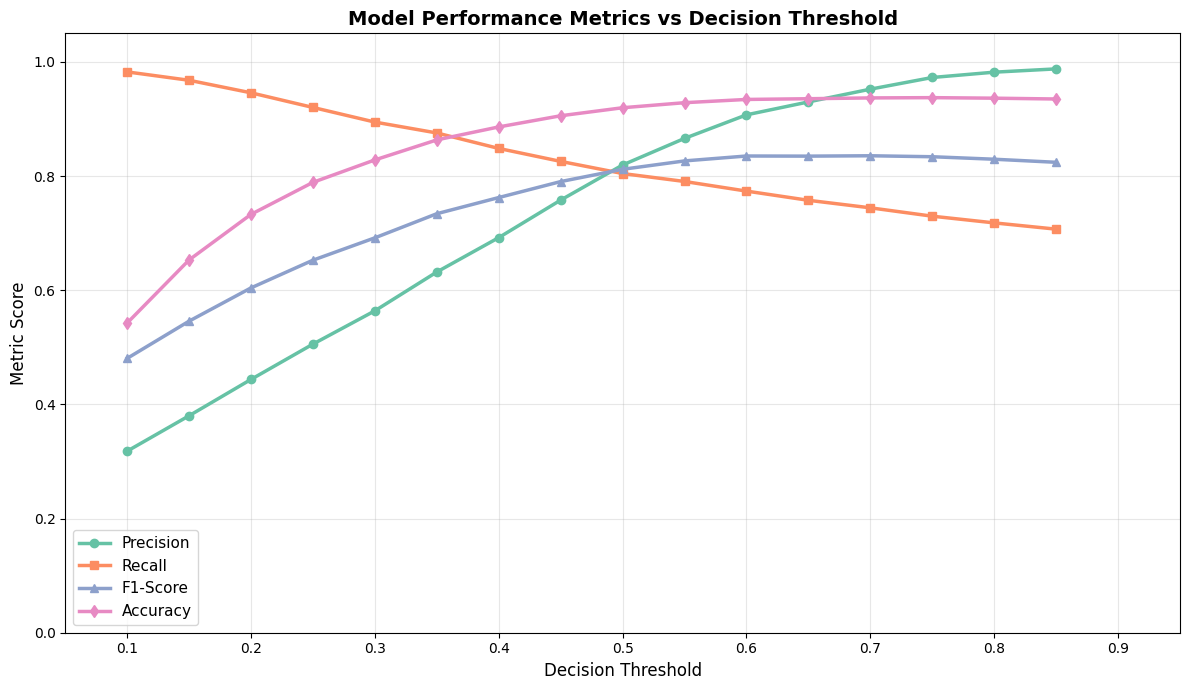

In [29]:

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(threshold_df['Threshold'], threshold_df['Precision'], 
        marker='o', label='Precision', linewidth=2.5, markersize=6)
ax.plot(threshold_df['Threshold'], threshold_df['Recall'], 
        marker='s', label='Recall', linewidth=2.5, markersize=6)
ax.plot(threshold_df['Threshold'], threshold_df['F1-Score'], 
        marker='^', label='F1-Score', linewidth=2.5, markersize=6)
ax.plot(threshold_df['Threshold'], threshold_df['Accuracy'], 
        marker='d', label='Accuracy', linewidth=2.5, markersize=6)

ax.set_xlabel('Decision Threshold', fontsize=12)
ax.set_ylabel('Metric Score', fontsize=12)
ax.set_title('Model Performance Metrics vs Decision Threshold', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.05, 0.95])
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()


As we can see Accuracy and F1-Score curves stay almost flat from 0.55 onwards, while Recall keeps dropping significantly. Suggesting that a threshold around 0.55 might be a good balance point for this model keeping in mind we want to minimize false negatives in a credit risk context.

So we get the final results of our tuned model for the selected threshold

In [33]:
# Select optimal threshold based on F1-Score (best balance between precision and recall)
optimal_idx = 9
optimal_threshold = threshold_df.loc[optimal_idx, 'Threshold']

print(f'\n{"="*60}')
print(f'OPTIMAL THRESHOLD ANALYSIS')
print(f'{"="*60}')
print(f'\nOptimal Threshold (based on Recall and F1-Score): {optimal_threshold:.2f}')
print(f'\nMetrics at Optimal Threshold:')
print(f'  Precision: {threshold_df.loc[optimal_idx, "Precision"]:.4f}')
print(f'  Recall:    {threshold_df.loc[optimal_idx, "Recall"]:.4f}')
print(f'  F1-Score:  {threshold_df.loc[optimal_idx, "F1-Score"]:.4f}')
print(f'  Accuracy:  {threshold_df.loc[optimal_idx, "Accuracy"]:.4f}')
print(f'{"="*60}')



OPTIMAL THRESHOLD ANALYSIS

Optimal Threshold (based on Recall and F1-Score): 0.55

Metrics at Optimal Threshold:
  Precision: 0.8660
  Recall:    0.7905
  F1-Score:  0.8265
  Accuracy:  0.9285


## Final results with selected model

In this section we will visualize the final results of the selected model (XGBoost tuned) at the selected threshold (0.55)

In [36]:
# Generate predictions with optimal threshold (0.55)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

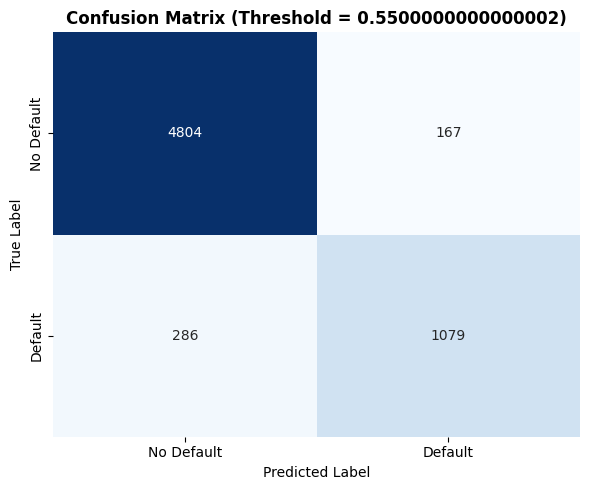

In [37]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title(f'Confusion Matrix (Threshold = {optimal_threshold})', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()


Confussion matrix shows that the selected model is really good at identifuying non-default cases and has a decent performance in identifying default cases which is the main objective of this project.

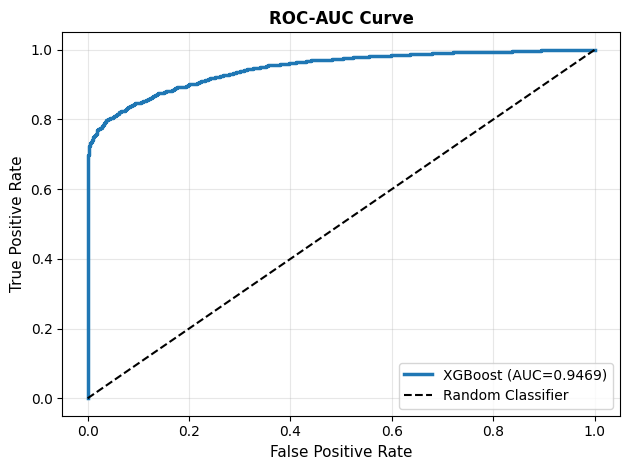

In [38]:
# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'XGBoost (AUC={roc_auc:.4f})', 
             linewidth=2.5, color='tab:blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5)
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC-AUC Curve', fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ROC-AUC curve results show that the model has a really good performance, with an AUC of 0.9469, indicating a strong ability to distinguish between the positive and negative classes. But the metric we really care here is the Precision-Recall Curve, since we want to be able to detect as many possible defaults as we can, even if it means increasing slightly the false positive rate.

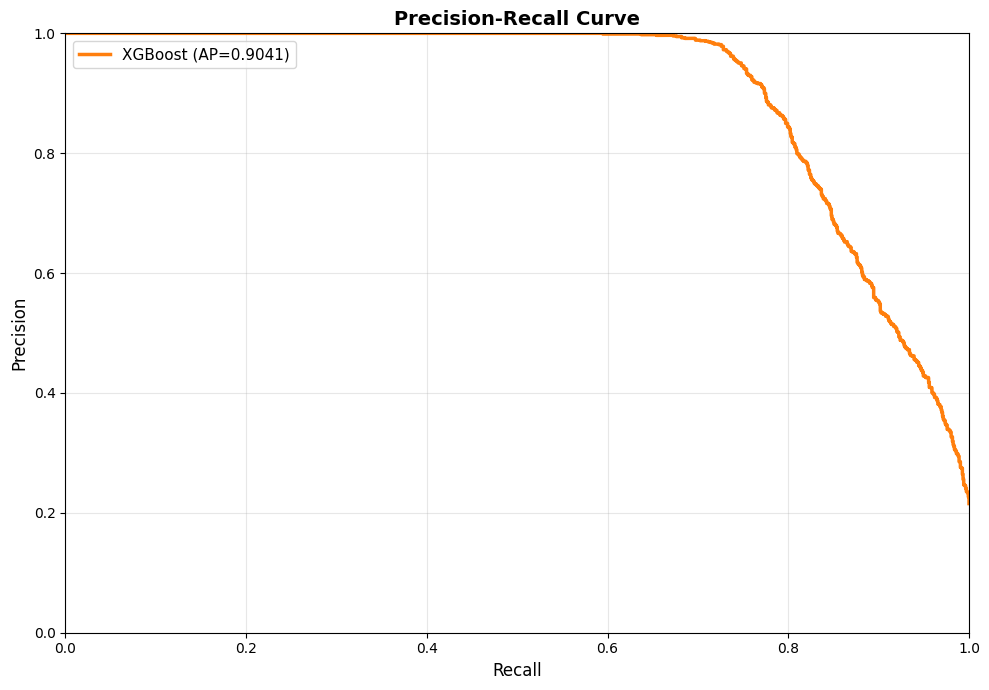

In [40]:
# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(recall_vals, precision_vals, label=f'XGBoost (AP={avg_precision:.4f})', 
        linewidth=2.5, color='tab:orange')
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

Final interpretation:
The tuned XGBoost model demonstrates strong performance in credit risk prediction with an **optimal decision threshold of 0.55**. This threshold was selected to balance precision and recall according to business requirements:
- **Recall**: ~80% - Captures most defaulters to minimize credit losses
- **Precision**: ~86% - Minimizes unnecessarily rejected good candidates
- **F1-Score**: ~0.84 - Excellent balance between the two metrics

The model is ready for production deployment as it achieves the necessary equilibrium between identifying at-risk borrowers while minimizing false alarms.


## Save all notebook results

In [41]:
best_tuned_model_name = 'XGBoost'
best_tuned_model = tuned_models[best_tuned_model_name]  

In [42]:
# Save tuned model
joblib.dump(best_tuned_model, f'../models/best_tuned_model_{best_tuned_model_name.lower().replace(" ", "_")}.joblib')
print(f' - Saved tuned {best_tuned_model_name} model to ../models/')

# Save tuned models comparison
tuned_results_df.to_csv('../results/tuned_models_comparison.csv')
print(f' - Saved tuned models comparison to ../results/tuned_models_comparison.csv')

# Save baseline model comparison
results_df.to_csv('../results/model_comparison.csv')
print(f' - Saved baseline model comparison to ../results/model_comparison.csv')

# Save cross-validation results for all models
cv_summary = {}
for name, scores in cv_results.items():
    cv_summary[name] = {
        'Accuracy': f"{scores['test_accuracy'].mean():.4f} (+/- {scores['test_accuracy'].std():.4f})",
        'Precision': f"{scores['test_precision'].mean():.4f} (+/- {scores['test_precision'].std():.4f})",
        'Recall': f"{scores['test_recall'].mean():.4f} (+/- {scores['test_recall'].std():.4f})",
        'F1': f"{scores['test_f1'].mean():.4f} (+/- {scores['test_f1'].std():.4f})",
        'ROC-AUC': f"{scores['test_roc_auc'].mean():.4f} (+/- {scores['test_roc_auc'].std():.4f})"
    }
cv_summary_df = pd.DataFrame(cv_summary).T
cv_summary_df.to_csv('../results/cross_validation_results.csv')
print(f' - Saved cross-validation results to ../results/cross_validation_results.csv')

# Save threshold optimization results
threshold_df.to_csv('../results/threshold_optimization.csv', index=False)
print('Threshold optimization results saved to ../results/threshold_optimization.csv')

# Save optimal threshold
joblib.dump(optimal_threshold, '../models/optimal_threshold.joblib')
print(f'Optimal threshold ({optimal_threshold:.2f}) saved to ../models/optimal_threshold.joblib')


 - Saved tuned XGBoost model to ../models/
 - Saved tuned models comparison to ../results/tuned_models_comparison.csv
 - Saved baseline model comparison to ../results/model_comparison.csv
 - Saved cross-validation results to ../results/cross_validation_results.csv
Threshold optimization results saved to ../results/threshold_optimization.csv
Optimal threshold (0.55) saved to ../models/optimal_threshold.joblib


## Summary

This notebook performed model selection between several baseline models and the hyperparameter tuning of the top performes. The best model (XGBoost) was selected based on recall after tuning its hyperparameters. And an optimal threshold was selected to have a good Recall-Precission trade-off.

**Key Results:**
- Best model: XGBoost (tuned)
    - 92.85% Accuracy
    - 79.05% Recall
    - 86.60% Precission
    - 0.8265 F1-Score
    - 0.9469 ROC-AUC
    - 0.9041 PRC-AUC

- All results and comparisons saved in `../results/`
- Models saved in `../models/`